In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
import scipy
import scipy.stats
from scipy.optimize import curve_fit
from pylab import exp
from scipy import optimize
from math import sqrt
import glob
import seaborn as sns
import h5py   
from matplotlib.colors import LogNorm, Normalize
from scipy.interpolate import interp1d

In [2]:
def deltat(time,ch1,ch2):
    half1= max(ch1)/2
    half2= max(ch2)/2
    i=0
    while ch1[i]<half1:
        i=i+1
    j=0
    while ch2[j]<half2:
        j=j+1
    t1= time[i]
    t2= time[j]
    dt= time[j]-time[i]
    return dt, t1 ,t2

def tot(time, ch):
    half= (max(ch)-min(ch))/2 + min(ch) #find half point of the rise
    i=0
    while ch[i]<half: #find the element which is higher then the halfpoint
        i=i+1
    x1= [time[i-1],time[i]]
    y1= [ch[i-1],ch[i]]
    xnew1= np.linspace(time[i-1],time[i],200)
    f1 = interp1d(x1, y1)#linearly interpolate of these two points
    ynew1= f1(xnew1)
    k=0
    while ynew1[k]<half:
        k=k+1#find the right point of the interpolation
    j=i+30 #no do the same for the falling edge
    while ch[j]>half:
        j=j+1
    
    x2= [time[j-1],time[j]]
    y2= [ch[j-1],ch[j]]
    xnew2= np.linspace(time[j-1],time[j],200)
    f2 = interp1d(x2, y2)
    ynew2= f2(xnew2)
    z=0
    while ynew2[z]<half:
        z=z+1
    tott= xnew2[z]- xnew1[k]#calculate the tot
    return tott

In [3]:
a=glob.glob("/home/pixel/Documents/Master_Thesis_Douwe_Nobels/Measurements/Calibration_scans_MPW2/cal_scan_P0_59V_P16_6ms_W50us_B100V/*")

a= sorted(a)

print(len(a))


110004


In [4]:
temp=[]
for i in range(3):
    f= h5py.File(a[i])
    temp.append(f)

In [5]:
print(temp[1].keys())

dset= temp[1]
ch1= dset["Voltage_CHAN1"]

ch1= np.array(ch1)

print(len(ch1))



<KeysViewHDF5 ['Time', 'Voltage_CHAN1', 'Voltage_CHAN2']>
16001


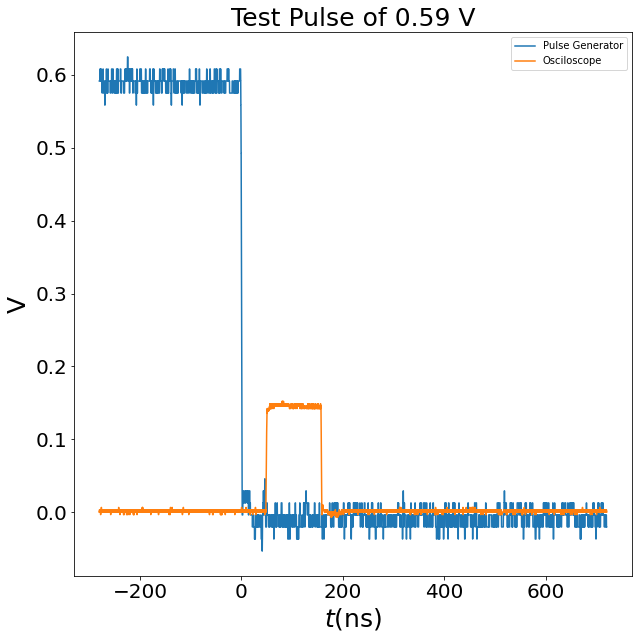

In [11]:
dset= temp[1]
ch1= dset["Voltage_CHAN1"]
ch1= np.array(ch1)
ch2= dset["Voltage_CHAN2"]
ch2= np.array(ch2)
arr=np.array(dset["Time"])*10**9



fig = plt.figure(figsize=(10,10))
plt.plot(arr,ch1, label="Pulse Generator")
plt.plot(arr,ch2, label="Osciloscope")


plt.legend()
fig.patch.set_facecolor('xkcd:white')
plt.xlabel("$t$(ns)",fontsize=25)
plt.title("Test Pulse of 0.59 V",fontsize=25)
plt.ylabel("V",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [7]:
%%time

pixelnames=[]
temp=[]
for i in range(len(a)):
    if i==0:
        temp.append(a[i])
    elif a[i]==a[-1]:
        temp.append(a[i])
        pixelnames.append(temp)
    elif a[i][130:136]==a[i-1][130:136]:
        temp.append(a[i])
    else:
        pixelnames.append(temp)
        temp=[]
        temp.append(a[i])

CPU times: user 55.1 ms, sys: 3.04 ms, total: 58.2 ms
Wall time: 59.8 ms


In [8]:
len(pixelnames)

64

In [9]:
%%time
pixelsdt=[]
pixelstot=[]
time=np.array(dset["Time"])

for i in range(len(pixelnames)):
    temp2=[]
    temp3=[]
    for j in range(len(pixelnames[i])):
        temp1=h5py.File(pixelnames[i][j])
        ch1= temp1["Voltage_CHAN1"]
        ch1= np.array(ch1)
        ch2= temp1["Voltage_CHAN2"]
        ch2= np.array(ch2)
        if max(ch2)<0.1:
            empty1.append(max(ch2))
        else:
            dt,t2,t3 =deltat(time,ch1,ch2)
            temp2.append(dt)
            temp3.append(tot(time,ch2))
        temp1.close()
    pixelsdt.append(temp2)
    pixelstot.append(temp3)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
CPU times: user 11min 45s, sys: 22.3 s, total: 12min 8s
Wall time: 13min 28s


In [10]:
datafile=[]

for i in range(len(pixelstot)):
    temp=[]
    for j in range(len(pixelstot[i])):
        temp.append(pixelstot[i][j])
    datafile.append(temp)
    
datafile= np.transpose(datafile)

np.savetxt("cal_scan_P0_59V_P16_6ms_W50us_B100V_tot",datafile, fmt='%s')

/home/pixel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [11]:
datafile1=[]

for i in range(len(pixelsdt)):
    temp=[]
    for j in range(len(pixelsdt[i])):
        temp.append(pixelsdt[i][j])
    datafile1.append(temp)
    
datafile1= np.transpose(datafile1)

np.savetxt("cal_scan_P0_59V_P16_6ms_W50us_B100V_deltat",datafile1, fmt='%s')



In [12]:
mintot=[]
for i in range(len(pixelstot)):
    mins= min(pixelstot[i])
    mintot.append(mins)

In [13]:
sig=[]
tot2=[]
for i in range(len(pixelstot)):
    mean= np.mean(pixelstot[i])
    sigs= np.std(pixelsdt[i])
    tot2.append(mean)
    sig.append(sigs)

In [14]:
sigmap= np.reshape(sig,(8,8))
totmap= np.reshape(tot2,(8,8))

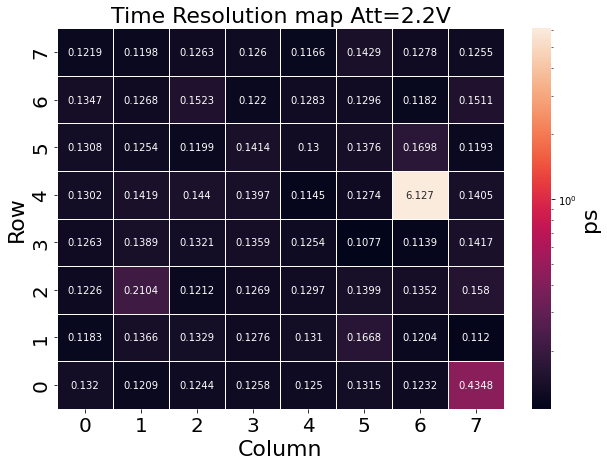

In [16]:
plt.figure(figsize = (10,7))
plt.title('Time Resolution map Att=2.2V',fontsize=22)
ax=sns.heatmap(sigmap*10**9, linewidth=0.5,norm=LogNorm(),annot=True, fmt='.4g')
ax.collections[0].colorbar.set_label("ps",fontsize=22)
plt.xlabel("Column",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Row',fontsize=22)
fig.patch.set_facecolor('xkcd:white')
sns.set_theme(style='white')
ax.invert_yaxis()
plt.show()

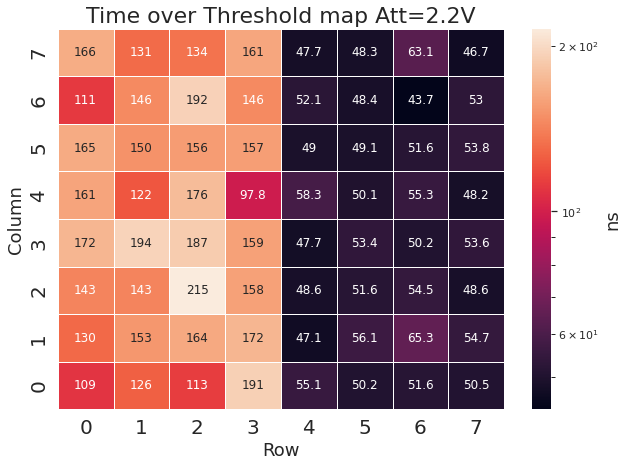

In [17]:
plt.figure(figsize = (10,7))
plt.title('Time over Threshold map Att=2.2V',fontsize=22)
ax=sns.heatmap(totmap*10**9, linewidth=0.5,norm=LogNorm(),annot=True, fmt='.3g')
ax.collections[0].colorbar.set_label("ns",fontsize=18)
plt.xlabel("Row",fontsize=18)
plt.ylabel('Column',fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.patch.set_facecolor('xkcd:white')
sns.set_theme(style='white')
ax.invert_yaxis()
plt.show()

In [18]:
totmap[0,3]
contot=[]
conres=[]
for i in range(4):
    for j in range(8):
        contot.append(totmap[j,i])
        conres.append(sigmap[j,i])

switchtot= []
switchres=[]
for i in range(4,8):
    for j in range(8):
        switchtot.append(totmap[j,i])
        switchres.append(sigmap[j,i])

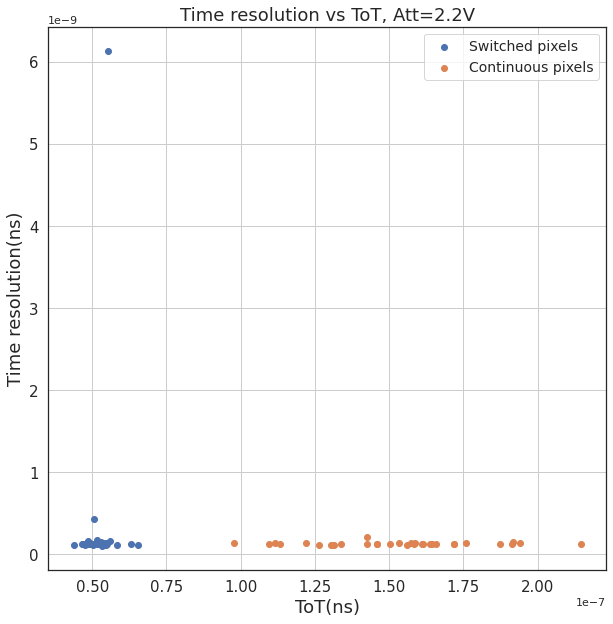

In [19]:
fig = plt.figure(figsize=(10,10))
plt.scatter(switchtot,switchres, label="Switched pixels")
plt.scatter(contot,conres, label="Continuous pixels")

plt.legend()
fig.patch.set_facecolor('xkcd:white')
plt.ylabel("Time resolution(ns)",fontsize=18)
plt.title("Time resolution vs ToT, Att=2.2V",fontsize=18)
plt.xlabel("ToT(ns)",fontsize=18)
plt.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=14)
plt.show()

In [20]:
timeres= conres

for i in range(len(switchres)):
    timeres.append(switchres[i])
    
    
totlist= contot

for i in range(len(switchtot)):
    totlist.append(switchtot[i])

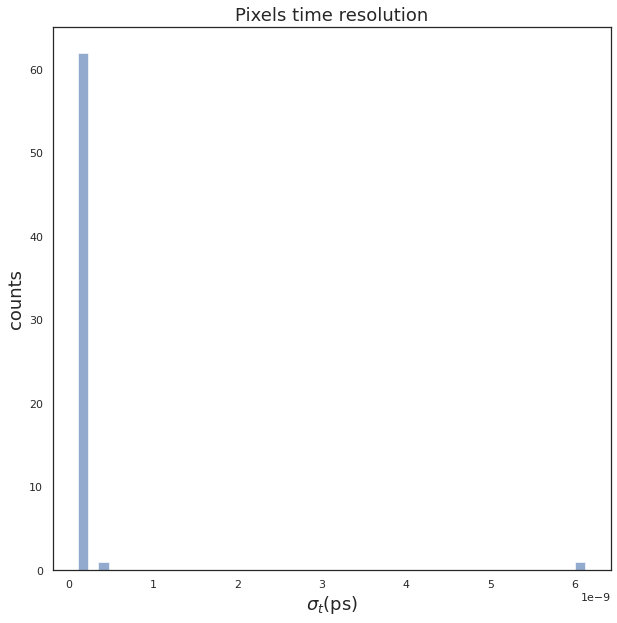

In [21]:
mean= np.mean(timeres)
std= np.std(timeres)
amount= len(timeres)
fig = plt.figure(figsize=(10,10))
plt.hist(timeres, bins=50, alpha=0.6, color='b')
plt.xlabel("$\sigma_t$(ps)",fontsize=18)
plt.ylabel("counts",fontsize=18)

plt.title("Pixels time resolution",fontsize=18)
fig.patch.set_facecolor('xkcd:white')
plt.plot([],[],label="mean={:.1f}".format(mean))
plt.plot([],[],label="std={:.1f}".format(std))
plt.plot([],[],"" ,label="number of entries {:.1f}".format(amount))
plt.annotate("mean={:.1f}".format(mean),xy=(1250,22),fontsize=14)
plt.annotate("std.dev.={:.1f}".format(std),xy=(1250,21),fontsize=14)
plt.annotate("number of entries {}".format(amount),xy=(1250,20),fontsize=14)





plt.show()

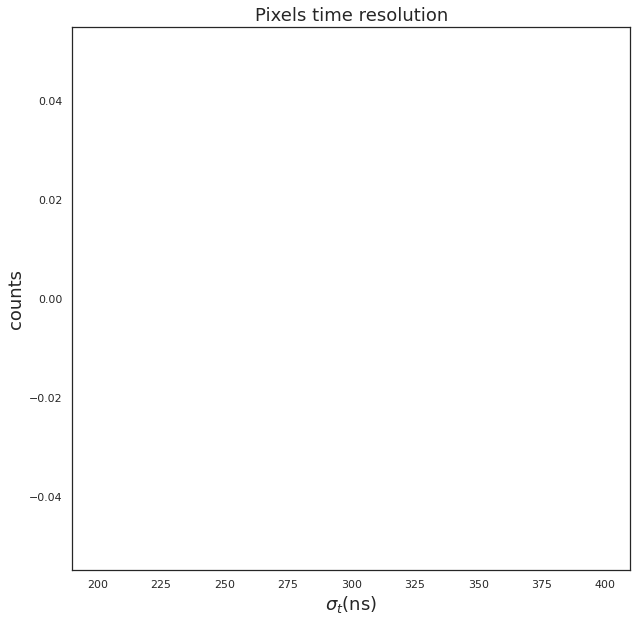

In [22]:
mean= np.mean(timeres)
std= np.std(timeres)
amount= len(timeres)
fig = plt.figure(figsize=(10,10))
plt.hist(timeres, bins=50, alpha=0.6, color='b',range=(200,400))
plt.xlabel("$\sigma_t$(ns)",fontsize=18)
plt.ylabel("counts",fontsize=18)

plt.title("Pixels time resolution",fontsize=18)
fig.patch.set_facecolor('xkcd:white')
plt.plot([],[],label="mean={:.1f}".format(mean))
plt.plot([],[],label="std={:.1f}".format(std))
plt.plot([],[],"" ,label="number of entries {:.1f}".format(amount))
plt.annotate("mean={:.1f}".format(mean),xy=(1250,22),fontsize=14)
plt.annotate("std={:.1f}".format(std),xy=(1250,21),fontsize=14)
plt.annotate("number of entries {}".format(amount),xy=(1250,20),fontsize=14)





plt.show()



In [23]:
new=[]

for i in range(len(timeres)):
    if timeres[i]<400:
        new.append(timeres[i])
        
    

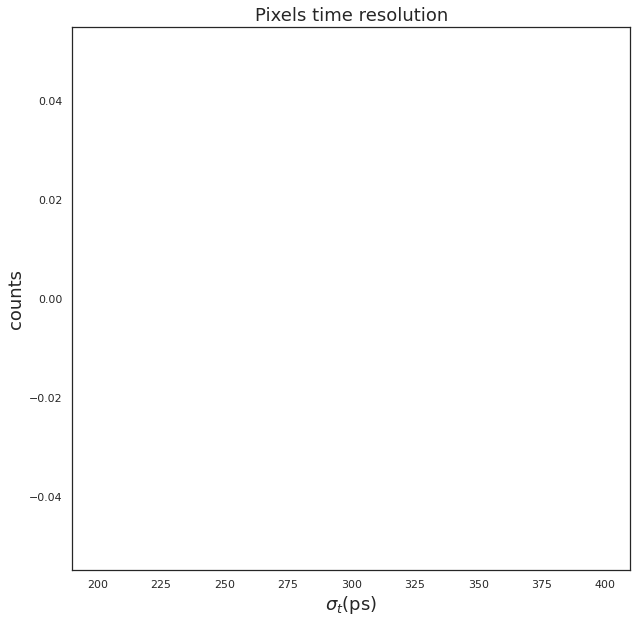

In [24]:
mean= np.mean(new)
std= np.std(new)
amount= len(new)
fig = plt.figure(figsize=(10,10))
plt.hist(new, bins=50, alpha=0.6, color='b',range=(200,400))
plt.xlabel("$\sigma_t$(ps)",fontsize=18)
plt.ylabel("counts",fontsize=18)

plt.title("Pixels time resolution",fontsize=18)
fig.patch.set_facecolor('xkcd:white')
plt.plot([],[],label="mean={:.1f}".format(mean))
plt.plot([],[],label="std={:.1f}".format(std))
plt.plot([],[],"" ,label="number of entries {:.1f}".format(amount))
plt.annotate("mean={:.1f}".format(mean),xy=(350,5),fontsize=14)
plt.annotate("std={:.1f}".format(std),xy=(350,4.75),fontsize=14)
plt.annotate("number of entries {}".format(amount),xy=(350,4.5),fontsize=14)





plt.show()

In [25]:
np.std(new)

7.440055830439537e-10

In [26]:
def q(tot):
    return (tot-36.10)/0.0084

In [27]:
charge=[]
for i in range(len(tot2)):
    ch= q(tot2[i])
    charge.append(ch)
    
chargemap= np.reshape(charge,(8,8))


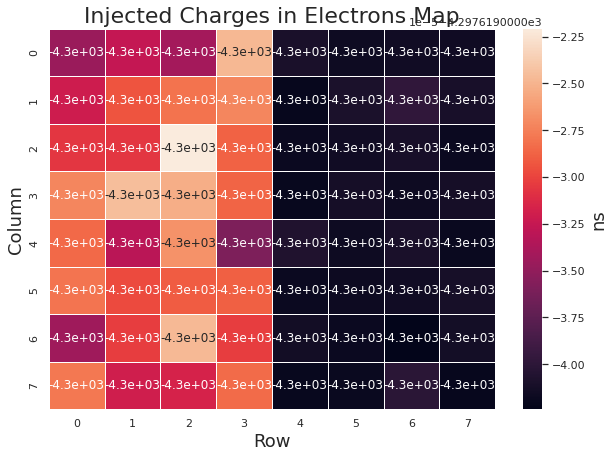

In [28]:
plt.figure(figsize = (10,7))
plt.title('Injected Charges in Electrons Map',fontsize=22)
ax=sns.heatmap(chargemap, linewidth=0.5,annot=True, fmt='.2g')
ax.collections[0].colorbar.set_label("ns",fontsize=18)
plt.xlabel("Row",fontsize=18)
plt.ylabel('Column',fontsize=18)
fig.patch.set_facecolor('xkcd:white')

plt.show()

In [29]:
tot2[-1]

4.667746642183798e-08

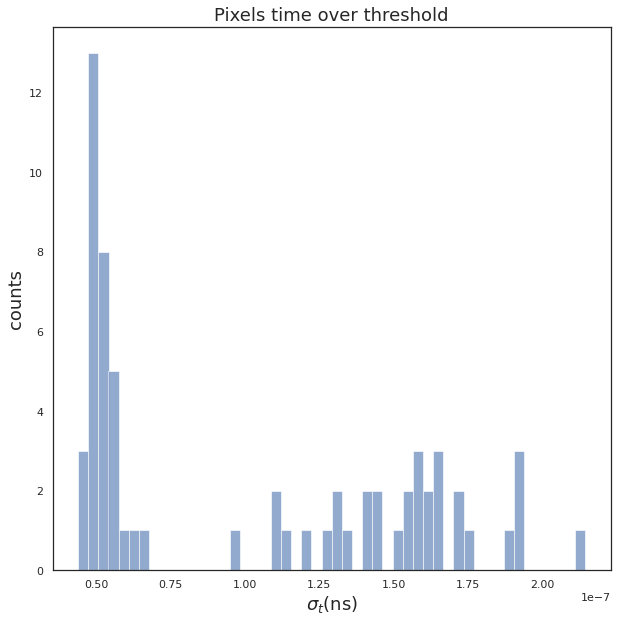

In [30]:
mean= np.mean(totlist)
std= np.std(totlist)
amount= len(totlist)
fig = plt.figure(figsize=(10,10))
plt.hist(totlist, bins=50, alpha=0.6, color='b')
plt.xlabel("$\sigma_t$(ns)",fontsize=18)
plt.ylabel("counts",fontsize=18)

plt.title("Pixels time over threshold",fontsize=18)
fig.patch.set_facecolor('xkcd:white')
plt.plot([],[],label="mean={:.1f}".format(mean))
plt.plot([],[],label="std={:.1f}".format(std))
plt.plot([],[],"" ,label="number of entries {:.1f}".format(amount))
plt.annotate("mean={:.1f}".format(mean),xy=(175,13),fontsize=14)
plt.annotate("std.dev={:.1f}".format(std),xy=(175,12.5),fontsize=14)
plt.annotate("number of entries {}".format(amount),xy=(175,12),fontsize=14)





plt.show()

In [31]:
test=pixelsdt[10]
np.std(test)*1000
amounts= len(pixelsdt[10])

In [32]:
def Gaussian(x,a,b,c):
    return a * exp(-(x - b)**2.0 / (2 * c**2))

In [33]:
det00=[]
for i in range(len(test)):
    det00.append(test[i]-np.mean(test))


 Curve-fit Curve fit: [66.43664097  0.32383547 50.65989301]

 Curve-fit Fit errors: [1.01330291e+05 7.02576282e+06 9.96828459e+08]


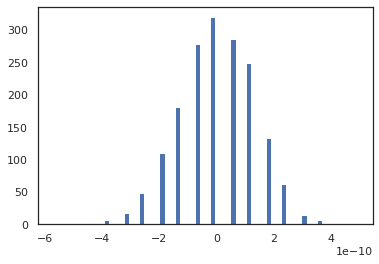

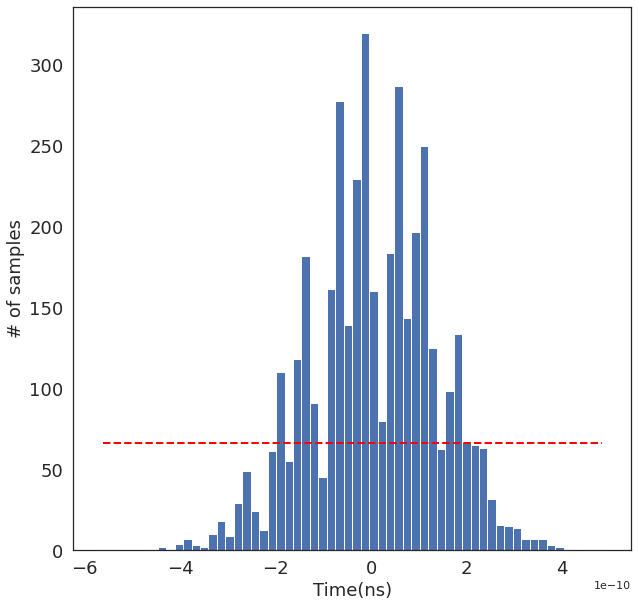

996828459236.2609


In [34]:
nbins=60
n,bins,patches = plt.hist(det00,bins=nbins)

fig = plt.figure(figsize=(10,10))

bin_size = abs(bins[1]-bins[0])
x =np.linspace(start=bins[0]+bin_size/2.0,stop=bins[-2]+bin_size/2.0,\
num=nbins,endpoint=True)


y = n
y[y==0]= 1e-8

for i in range(len(n)):
    if n[i] ==1e-8:
        n[i]= (n[i-1]+n[i+1])/2






popt, pcov = optimize.curve_fit(Gaussian,x,n) 

# Curve-fit error method
error = [] 
for i in range(len(popt)):
    try:
      error.append( np.absolute(pcov[i][i])**0.5)
    except:
      error.append( 0.00 )
pfit_curvefit = popt
perr_curvefit = np.array(error) 
print('\n Curve-fit Curve fit: %s' % pfit_curvefit)
print('\n Curve-fit Fit errors: %s' % perr_curvefit)


std=popt[2]*1000
amount=nbins
# Plot the fit
x_fit = np.linspace(x[0], x[-1], nbins)
y_gauss = Gaussian(x_fit, *popt)
yerr=Gaussian(x_fit,*perr_curvefit)
plt.bar(x,n, width=bin_size)
plt.plot(x_fit, y_gauss,linestyle='--',linewidth=2,\
color='red',label='Gaussian')

chi_square_test_statistic1 = 0
for i in range(len(n)):
    chi_square_test_statistic1 = chi_square_test_statistic1 + \
        (np.square(n[i]-y_gauss[i]))/y_gauss[i]

chi2=chi_square_test_statistic1
plt.annotate("std.dev={:.1f}ps".format(std),xy=(0.5,110),fontsize=14)
plt.annotate("number of bins: {}".format(amount),xy=(0.5,105),fontsize=14)
plt.annotate("number of samples: {}".format(amounts),xy=(0.5,100),fontsize=14)
plt.annotate("$\chi^2$ ={:.2f}".format(chi2),xy=(0.5,95),fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Time(ns)",fontsize=18)
plt.ylabel("# of samples",fontsize=18)

plt.show()
print(perr_curvefit[2]*1000)

In [35]:
hits=[]
realhits=[]

pixtot=[]
pixdt=[]
pixmean=[]

for i in range(len(pixelnames)):
    realhits.append(len(pixelstot[i]))
    hits.append(len(pixelnames[i]))
    if len(pixelstot)==0:
        pixtot.append(0)
        pixdt.append(0)
    else:
        pixtot.append(np.mean(pixelstot[i]))
        pixdt.append(np.mean(pixelsdt[i]))


print(realhits)

[1669, 1722, 1721, 1727, 1714, 1721, 1723, 1711, 1720, 1726, 1723, 1721, 1705, 1722, 1715, 1726, 1711, 1729, 1727, 1735, 1721, 1711, 1719, 1715, 1722, 1719, 1722, 1702, 1716, 1717, 1709, 1709, 1722, 1711, 1707, 1722, 1737, 1723, 1709, 1718, 1720, 1716, 1714, 1732, 1719, 1724, 1725, 1734, 1717, 1724, 1727, 1705, 1715, 1726, 1715, 1711, 1719, 1710, 1733, 1712, 1722, 1720, 1732, 1733]


In [36]:
totmap= np.reshape(pixtot,(8,8))


per=[]

for i in range(len(hits)):
    per.append((realhits[i]/hits[i])*100)
    
permap=np.reshape(per,(8,8))

np.mean(hits)

1718.8125

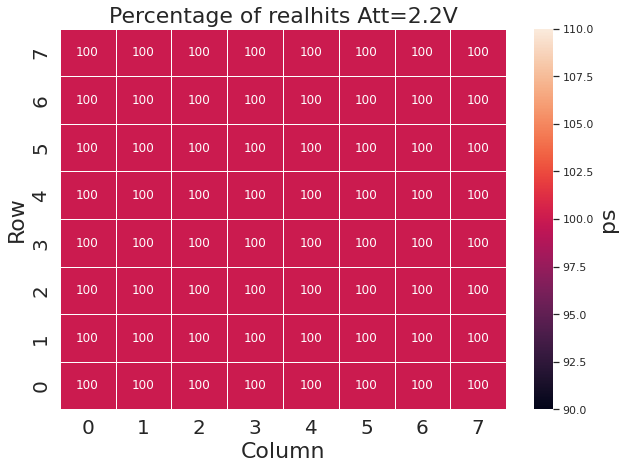

In [37]:
plt.figure(figsize = (10,7))
plt.title('Percentage of realhits Att=2.2V',fontsize=22)
ax=sns.heatmap(permap, linewidth=0.5,annot=True, fmt='.4g')
ax.collections[0].colorbar.set_label("ps",fontsize=22)
plt.xlabel("Column",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Row',fontsize=22)
fig.patch.set_facecolor('xkcd:white')
sns.set_theme(style='white')
ax.invert_yaxis()
plt.show()